This python script uses a Long Short-Term Memory network to predict sequences of optical signals.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


## Load the dataset

In [2]:
df = pd.read_csv('Intensity_Rare_Events.dat',sep='\t').iloc[0:4000,:]
df.head()

,t,I
0,0.038148,0.027355
1,0.114443,0.032728
2,0.190738,0.045104
3,0.267033,0.068821
4,0.343328,0.110740


## Explore the dataset

In [3]:
t = df.iloc[:,0] #time
I = df.iloc[:,1]/df.iloc[:,1].max() #intensity

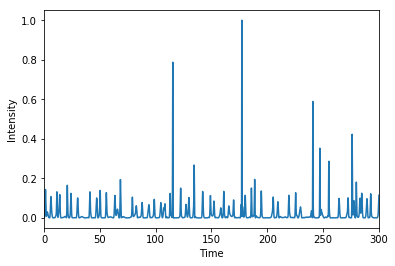

In [4]:
plt.plot(t,I)
plt.ylabel('Intensity')
plt.xlabel('Time')
plt.xlim([0,300])
plt.show()

## Convert an array of values into a dataset matrix

In [5]:
# time step
dt = t[1]-t[0]
dt

0.076295

In [6]:
# number of points to look back
look_back =int(10/dt)
look_back

131

In [7]:
# convert an array of values into a dataset matrix
y_seq = []
y_next = [] 

for i in range(len(I)-look_back-1):
    a = I[i:(i+look_back)]
    y_seq.append(a)
    y_next.append(I[i + look_back])
    
y_seq = np.array(y_seq)
y_next = np.array(y_next)

In [8]:
y_seq.shape

(3868, 131)

In [9]:
y_next.shape

(3868,)

## Split into train and test sets

In [10]:
train_size = int(y_seq.shape[0] * 0.67)
test_size = y_seq.shape[0] - train_size
y_seq_train, y_seq_test = y_seq[0:train_size,:], y_seq[train_size:y_seq.shape[0],:]
y_next_train, y_next_test = y_next[0:train_size], y_next[train_size:y_seq.shape[0]]

## Reshape input to be [samples, time steps, features]

In [11]:
y_seq_train = np.reshape(y_seq_train, (y_seq_train.shape[0], y_seq_train.shape[1], 1))
y_seq_test = np.reshape(y_seq_test, (y_seq_test.shape[0], y_seq_test.shape[1], 1))

## Create and fit the LSTM network

In [12]:
model = Sequential()
model.add(LSTM(10, activation= 'linear', input_shape=(look_back, 1)))#10 units
model.add(Dense(1, activation= 'linear'))

In [13]:
model.compile(loss='mean_squared_error', optimizer='adam')#adam
model.fit(y_seq_train, y_next_train, epochs=5, batch_size=200)

Epoch 1/5
2591/2591 [==============================] - 8s - loss: 0.0013     
Epoch 2/5
2591/2591 [==============================] - 7s - loss: 0.0012     
Epoch 3/5
2591/2591 [==============================] - 6s - loss: 0.0012     
Epoch 4/5
2591/2591 [==============================] - 7s - loss: 0.0011     
Epoch 5/5
2591/2591 [==============================] - 6s - loss: 0.0011      


## Make predictions

In [14]:
y_next_train_pred = model.predict(y_seq_train)
y_next_test_pred = model.predict(y_seq_test)

In [15]:
mean_squared_error(y_next_test, y_next_test_pred)

0.0009074304767436879

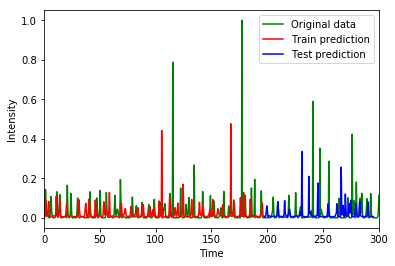

In [16]:
plt.plot(t,I, c='g', label = 'Original data')
plt.plot(np.arange(0,train_size)*dt,y_next_train_pred, c='r', label='Train prediction')
plt.plot(np.arange(train_size,y_seq.shape[0])*dt,y_next_test_pred, c='b', label='Test prediction')
plt.ylabel('Intensity')
plt.xlabel('Time')
plt.xlim([0,300])
plt.legend()
plt.show()